In [163]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

### Load model

In [164]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [165]:
N = 150
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [166]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [167]:
w_list_transfer = [1]
zeta_list = [0.0]
forcing_list = [forcing.zeroes_2D(numpy=True)]
ic_list = [[1, 0]]
epsilon_list = [0.6]
p_list = [5]
q = [(3, 1)]

In [168]:
ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list[0], forcing_1D=lambda t: np.zeros_like(t), q=q, epsilon=epsilon_list[0])
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

## Standard Perturbation

In [169]:
NN_TL_solution_standard, perturbation_solution_standard, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard = NN_TL_solution_standard.squeeze()

In [170]:
NN_TL_solution_standard, perturbation_solution_standard, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard = NN_TL_solution_standard.squeeze()

PINN_x_solution_standard = [perturbation_solution_standard[i][:, 0] for i in range(len(perturbation_solution_standard))]
PINN_x_solution_series_standard = standard.calculate_general_series(PINN_x_solution_standard, epsilon=epsilon_list[0])

In [171]:
PINN_x_solution_standard = [perturbation_solution_standard[i][:, 0] for i in range(len(perturbation_solution_standard))]
PINN_x_solution_series_standard = standard.calculate_general_series(PINN_x_solution_standard, epsilon=epsilon_list[0])

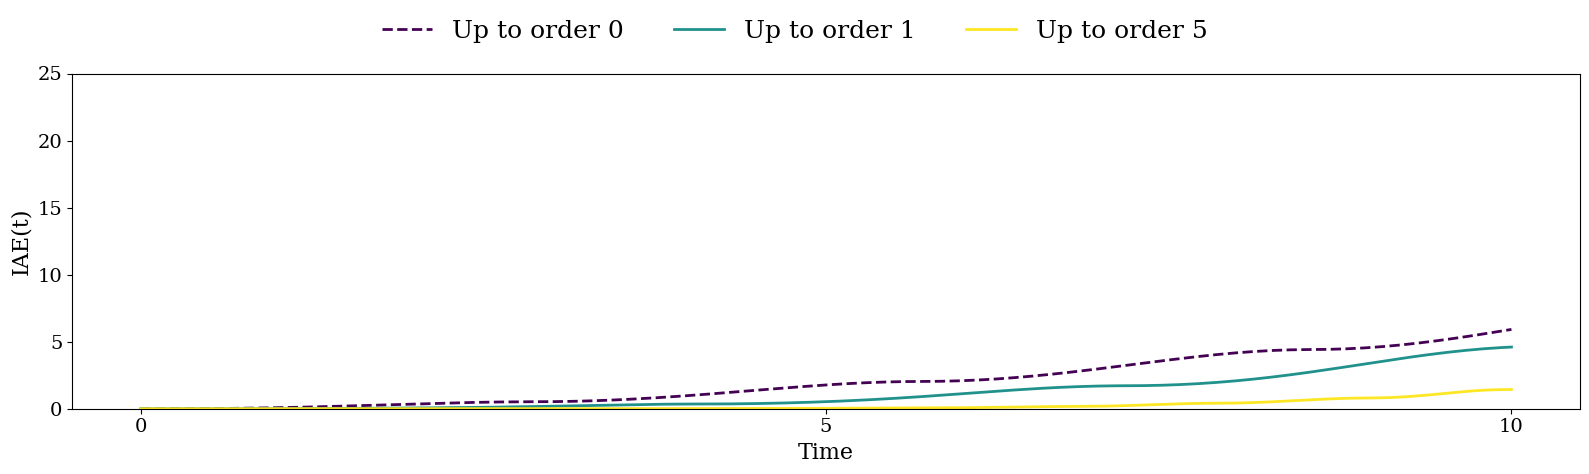

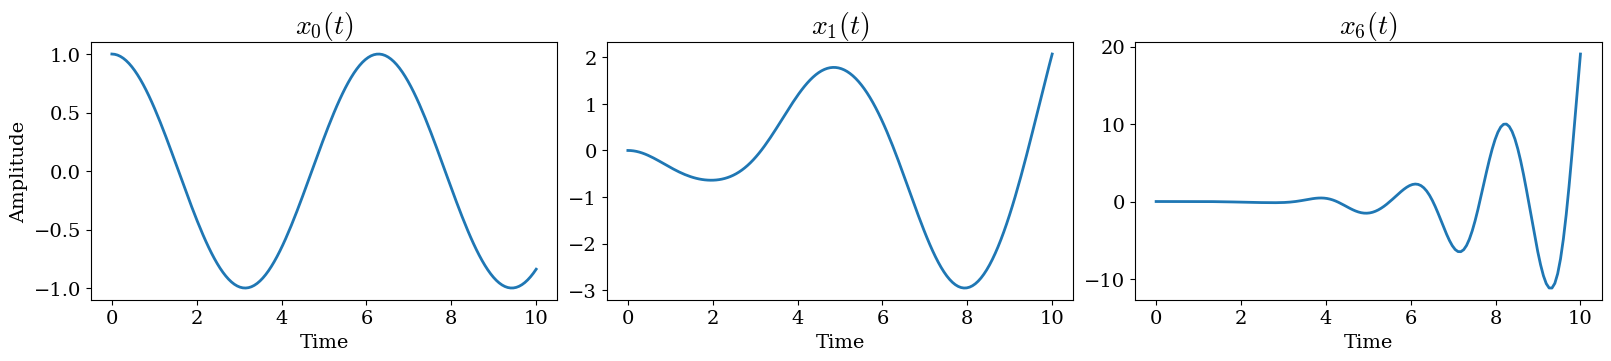

In [172]:
standard.plot_IAE_and_subplots(PINN_x_solution_series_standard, numerical_undamped_duffing, perturbation_solution_standard, t_eval, selected_orders=[0, 1, 5])

## Lindstedt-Poincare method

In [173]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol, power=q)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [174]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

[[1,
  np.float64(1.2241276097189773),
  np.float64(1.1948845983244494),
  np.float64(1.2032762450487762),
  np.float64(1.2001243752667192),
  np.float64(1.2014741211396311)]]

In [175]:
_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
w_teor

np.float64(1.2018028846153845)

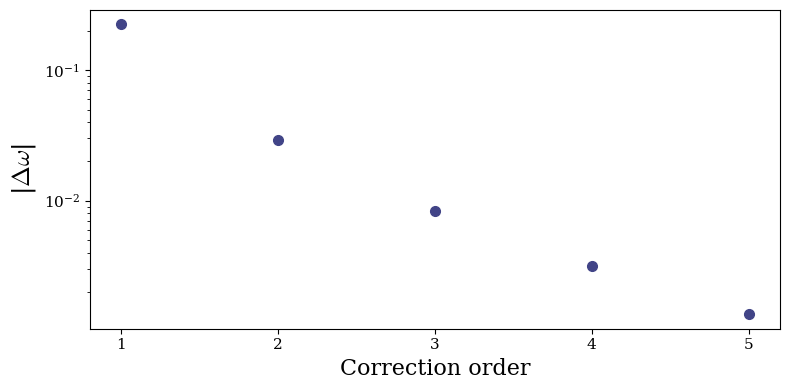

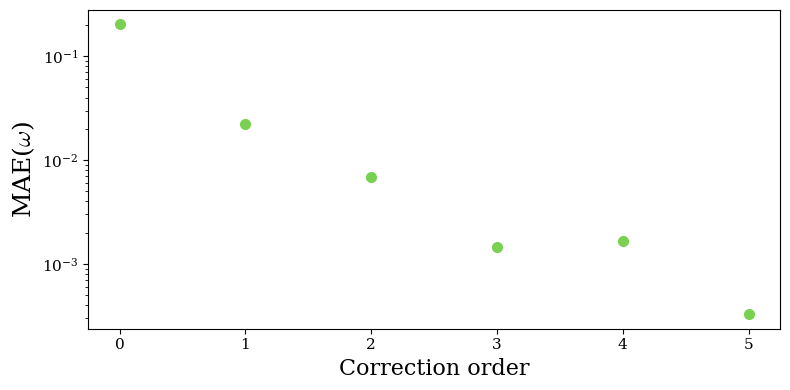

In [176]:
LPM.relative_error(w_final_list[0])
LPM.w_absolute_error(w_final_list[0], w_teor)

In [177]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

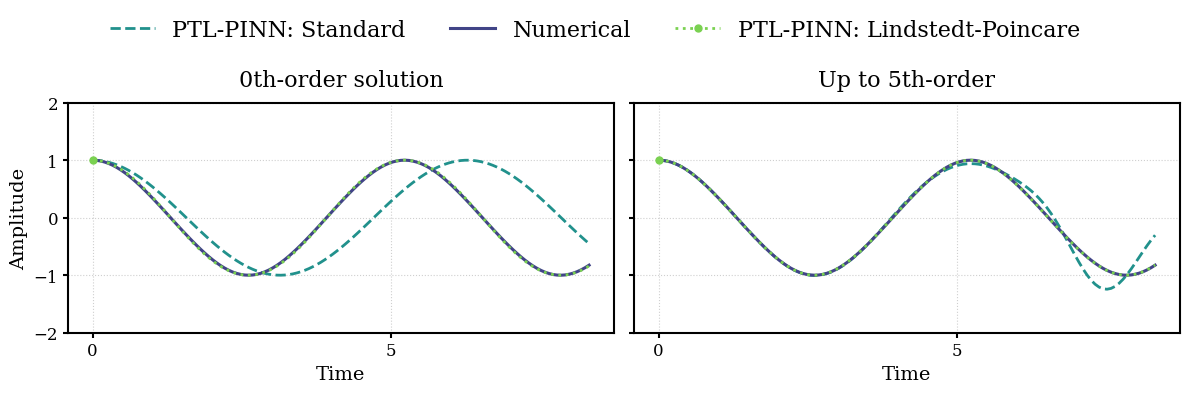

In [178]:
standard.plot_comparison_standard_vs_lpm(t_eval_standard, t_eval_lpm, [i[:compare_len] for i in perturbation_solution_standard], NN_TL_solution_standard[:compare_len], perturbation_solution_LPM, NN_TL_solution_LPM, numerical_undamped_duffing[:, :compare_len], order=p_list[0])

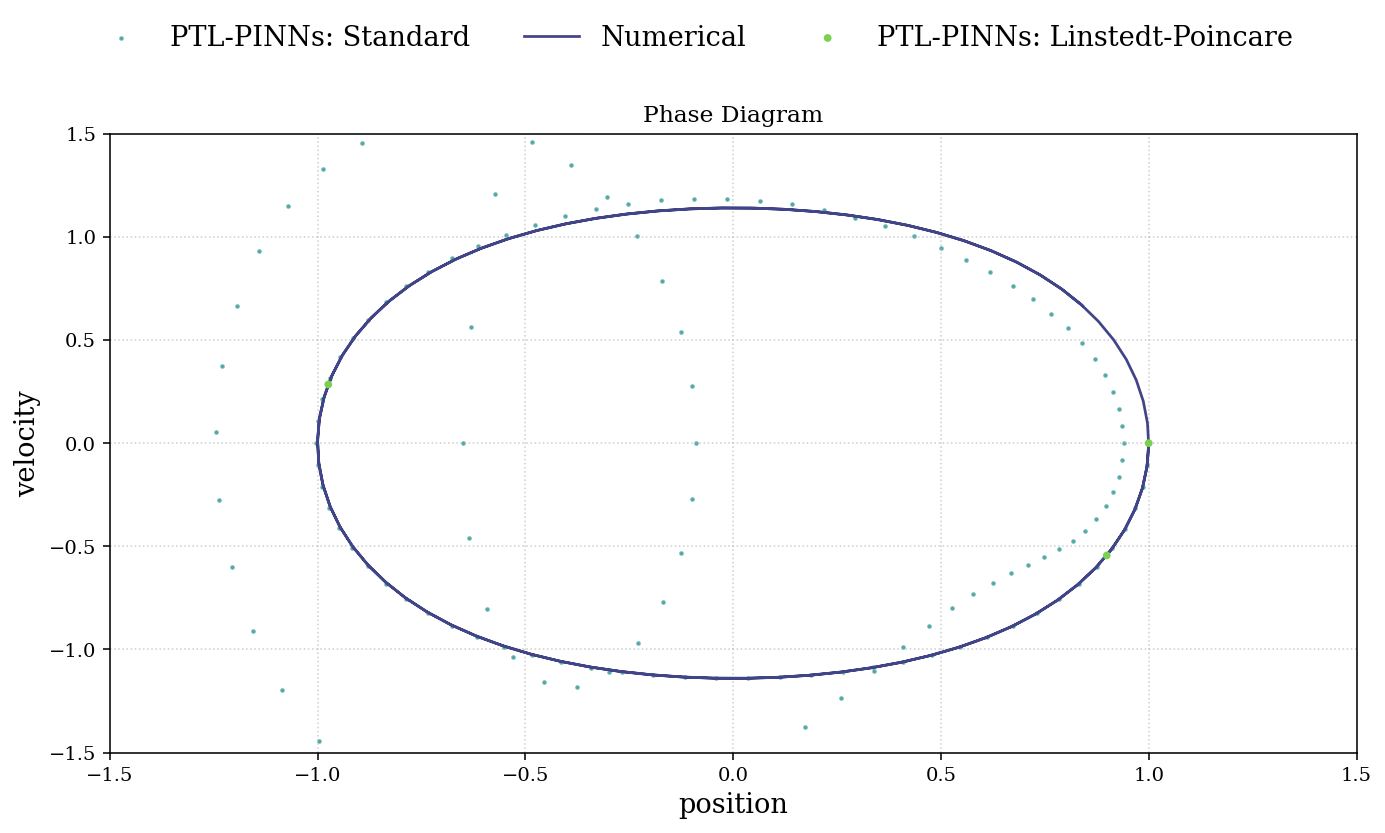

In [179]:
LPM.plot_multiple_phase_diagrams(
    [NN_TL_solution_LPM, numerical_undamped_duffing, NN_TL_solution_standard],
    labels=["PTL-PINNs: Linstedt-Poincare", "Numerical", "PTL-PINNs: Standard"],
    lpm_index=0,
    omega=w_teor,
    lpm_stride=50,
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5))

/tmp/ipykernel_149987/1663168197.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


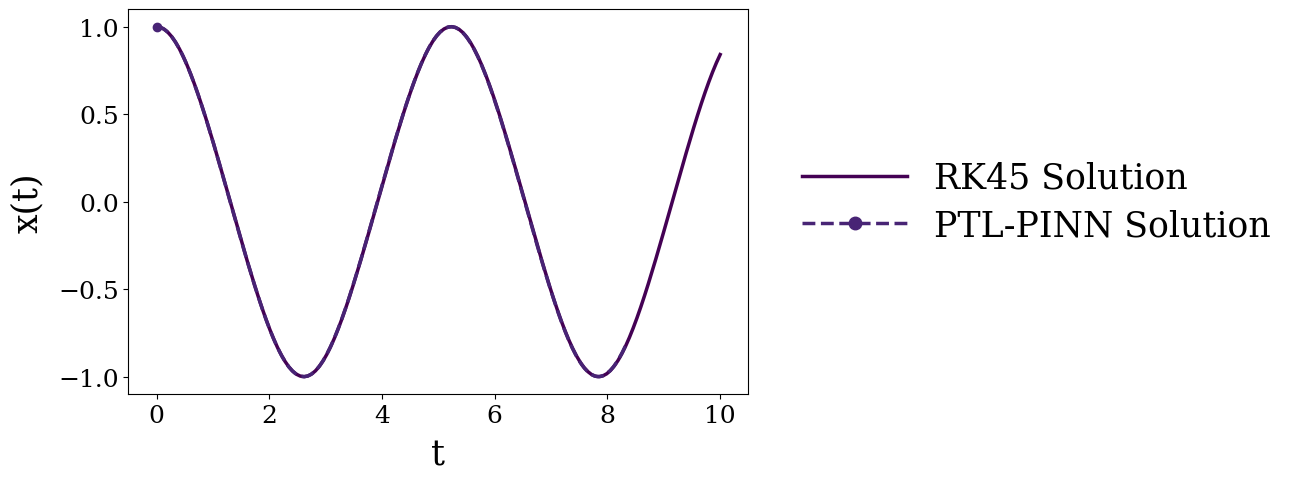

In [180]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, t_eval_lpm, y_num, y_nn, i = 0):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)


    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval_lpm, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval[:4000], t_eval_lpm[:4800], numerical_undamped_duffing[0, :4000], NN_TL_solution_LPM[:4800, 0], i = 0)

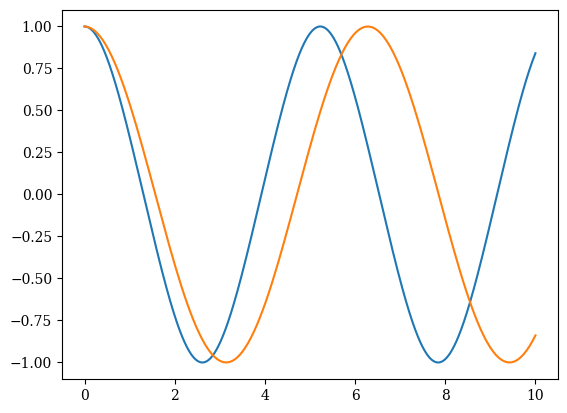

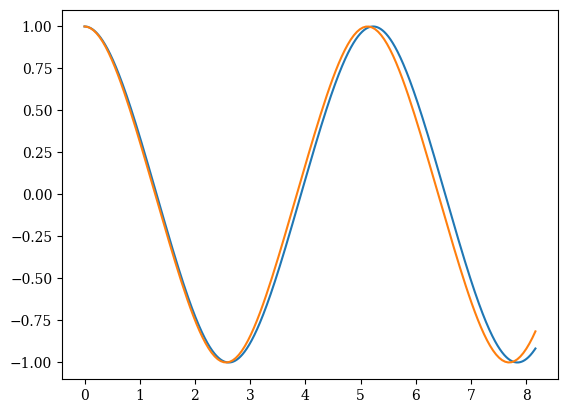

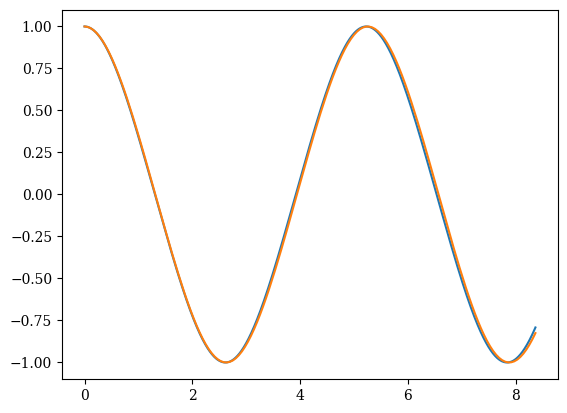

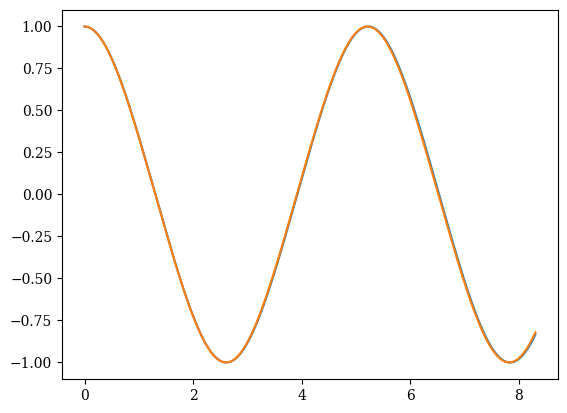

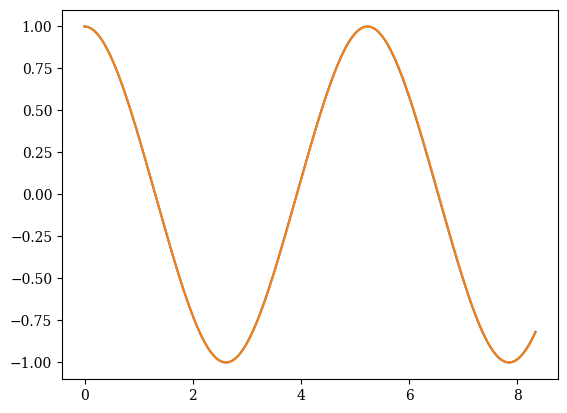

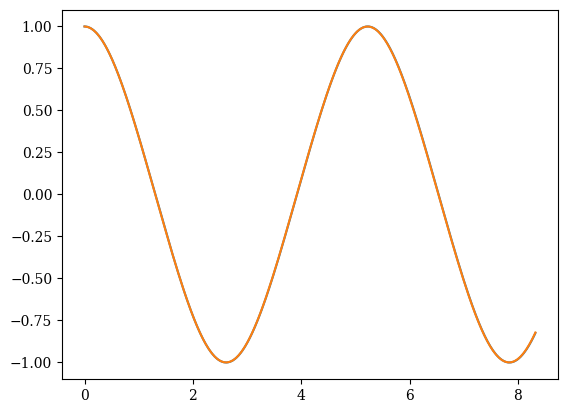

In [181]:
w_final = []
xi_final = []
error = []
epsilon = epsilon_list[0]

for i in range(len(w_sol[0])):

    w_loop = w_final_list[0][i]

    if i == 0:
        xi_loop = perturbation_solution_LPM[0][:, 0]
    else:
        xi_loop  = xi_final[i - 1] + (epsilon ** i) * perturbation_solution_LPM[i][:, 0]

    w_final.append(w_loop)
    xi_final.append(xi_loop)

    t_span_loop = (0, t_span[-1]/w_loop)
    t_eval_loop_ptl = np.linspace(t_span_loop[0], t_span_loop[1], N)
    dt = (t_eval_loop_ptl[1] - t_eval_loop_ptl[0])/100
    #t_eval_loop = np.arange(t_span_loop[0], t_span_loop[1] + dt, dt)
    t_eval_loop = np.linspace(t_span_loop[0], t_span_loop[1], (t_eval_loop_ptl.size - 1)*100 + 1)
    x_loop = numerical.solve_ode_equation(ode, (t_eval_loop[0], t_eval_loop[-1]), t_eval_loop, ic_list[0])[0, :]

    error.append(np.mean(np.abs(xi_loop - x_loop[::100])))

    plt.plot(t_eval_loop, x_loop)
    plt.plot(t_eval_loop_ptl, xi_loop)
    plt.show()

In [182]:
error

[np.float64(0.5930635169083978),
 np.float64(0.05801621074494585),
 np.float64(0.015784562183785877),
 np.float64(0.006181722147896021),
 np.float64(0.002197050550992827),
 np.float64(0.00146205729730111)]

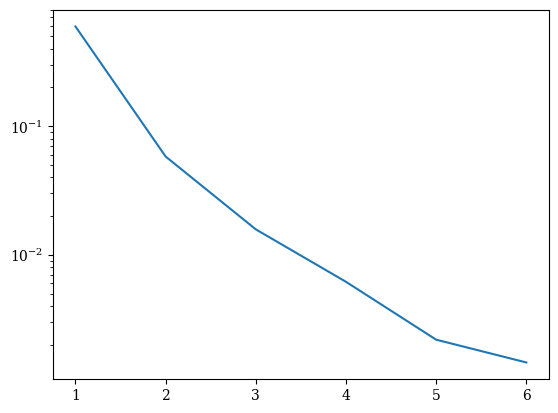

In [183]:
plt.semilogy([1, 2, 3, 4, 5, 6], error) 

In [184]:
scale = int(10000 / N)
scale

66

In [ ]:
dt = (t_eval[1] - t_eval[0])/scale
t_eval_high_acc = np.linspace(t_span[0], t_span[1], (t_eval.size - 1)*scale + 1)
num_high_acc = numerical.solve_ode_equation(ode, (t_eval_high_acc[0], t_eval_high_acc[-1]), t_eval_high_acc, ic_list[0])[0, :]
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

In [186]:
num_low_acc = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-3, atol=1e-3, method="Radau")[0, :]
np.mean(np.abs(num_low_acc - num_high_acc[::scale]))

np.float64(7.567040464387288e-05)

In [187]:
num_low_acc = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-3, atol=1e-3, method="RK45")[0, :]
np.mean(np.abs(num_low_acc - num_high_acc[::scale]))

np.float64(0.011078827721122115)

```
N = 50:

[np.float64(0.59395058323818),
 np.float64(0.06193823471411859),
 np.float64(0.014467081423215072),
 np.float64(0.00873336344175275),
 np.float64(0.0010801674882686767),
 np.float64(0.003808201463876767)]

N = 100:

[np.float64(0.5937182654708175),
 np.float64(0.05778914961089404),
 np.float64(0.015459861622546383),
 np.float64(0.006181762098097469),
 np.float64(0.002037665435471238),
 np.float64(0.0015764518087174302)]

N = 200:

[np.float64(0.5926731596035256),
 np.float64(0.057332964825109425),
 np.float64(0.0155986697131704),
 np.float64(0.005878531436699719),
 np.float64(0.0022229390874822464),
 np.float64(0.0012795728957352898)]

N = 400:

[np.float64(0.5920578936549693),
 np.float64(0.057400538977083936),
 np.float64(0.015856666317308015),
 np.float64(0.005819952944941594),
 np.float64(0.002407187327485573),
 np.float64(0.0011712735520655378)]

N = 500:

[np.float64(0.5919378318053234),
 np.float64(0.05729091914750443),
 np.float64(0.01581753994294092),
 np.float64(0.005771202079302991),
 np.float64(0.0024056133104278176),
 np.float64(0.0011442754452036439)]

[np.float64(0.003808201463876767), np.float64(0.0015764518087174302), np.float64(0.0012795728957352898), np.float64(0.0011712735520655378), np.float64(0.0011442754452036439)]
```